<a href="https://colab.research.google.com/github/lovecrushfamily/2021-CS109A/blob/master/content/lectures/lecture18/notebook/hyper_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Title :

Exercise: Hyperparameter tuning

## Description :

### Tuning the hyperparameters

Random Forests perform very well out-of-the-box, with the pre-set hyperparameters in sklearn. Some of the tunable parameters are:

- The number of trees in the forest: n_estimators, int, default=100
- The complexity of each tree: stop when a leaf has <= min_samples_leaf samples
- The sampling scheme: number of features to consider at any given split: max_features {“auto”, “sqrt”, “log2”}, int or float, default=”auto”.

## Instructions:

- Read the datafile diabetes.csv as a Pandas data frame.
- Assign the predictor and response variable as mentioned in the scaffold.
- Split the data into train and validation sets.
- Define a vanilla Random Forest and fit the model on the entire data.
- For various hyper parameters of the model, define different Random Forest models and train on the data.
- Compare the results with each model.

## Hints:

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">RandomForestClassifier()</a>
Defines the RandomForestClassifier and includes more details on the definition and range of values for its tunable parameters.

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba" target="_blank">model.predict_proba(X)</a>
Predict class probabilities for X

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html" target="_blank">roc_auc(y_test, y_proba)</a>
Calculates the area under the receiver operating curve (AUC).

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank">GridSearchCV()</a>
Performes exhaustive search over specified parameter values for an estimator.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
%matplotlib inline


In [6]:
# Read the dataset and take a quick look
df = pd.read_csv("https://raw.githubusercontent.com/lovecrushfamily/2021-CS109A/refs/heads/master/content/lectures/lecture18/data/diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# Assign the predictor and response variables.
# Outcome is the response and all the other columns are the predictors
X = df.drop("Outcome", axis=1)
y = df['Outcome']


In [9]:
# Set the seed for reproducibility of results
seed = 0

# Split the data into train and test sets with the mentioned seed
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=seed)


### Vanila random forest

Start by training a Random Forest Classifier using the default parameters and calculate the Receiver Operating Characteristic Area Under the Curve (ROC AUC). As we know, this metric is better than accuracy for a classification problem, since it covers the case of an imbalanced dataset.

In [13]:
### edTest(test_vanilla) ###

# Define a Random Forest classifier with randon_state = seed
vanilla_rf = RandomForestClassifier(random_state=seed)

# Fit the model on the entire data
vanilla_rf.fit(X_train, y_train);

# Calculate AUC/ROC on the test set
y_proba = vanilla_rf.predict_proba(X_test)[:, 1]
auc = np.round(roc_auc_score(y_test, y_proba),2)
print(f'Plain RF AUC on test set:{auc}')


Plain RF AUC on test set:0.83


In [14]:
# Number of samples and features
num_features = X_train.shape[1]
num_samples = X_train.shape[0]
num_samples, num_features


(514, 8)

### 1. Number of trees, `num_iterators`, default = 100

The number of trees needs to be large enough for the $oob$ error to stabilize in its lowest possible value. Plot the $oob$ error of a random forest as a function of the number of trees. Trees in a RF are called `estimators`. A good start is 10 times the number of features, however, adjusting other hyperparameters will influence the optimum number of trees.

In [15]:
%%time
from collections import OrderedDict
clf = RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               min_samples_leaf=40,
                               max_depth = 10,
                               random_state=seed)

error_rate = {}

# Range of `n_estimators` values to explore.
min_estimators = 150
max_estimators = 500

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(X_train.values, y_train.values)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error


CPU times: user 59.1 s, sys: 463 ms, total: 59.6 s
Wall time: 1min 1s


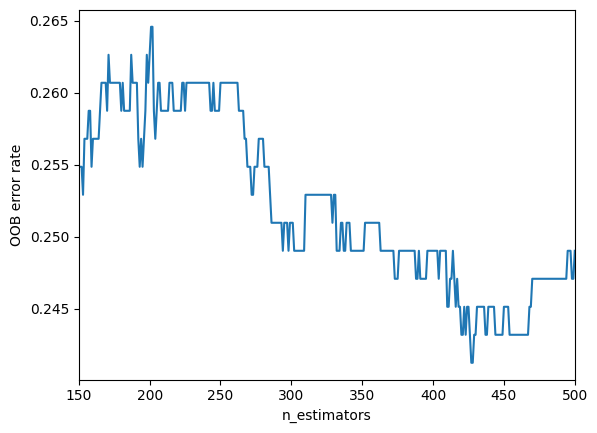

CPU times: user 153 ms, sys: 6.01 ms, total: 159 ms
Wall time: 159 ms


In [16]:
%%time
# Generate the "OOB error rate" vs. "n_estimators" plot.
# OOB error rate = num_missclassified/total observations (%)\
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)
plt.plot(xs, ys)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show();


### 2. `min_samples_leaf`, default = 1

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. We will plot various values of the `min_samples_leaf` with `num_iterators`.

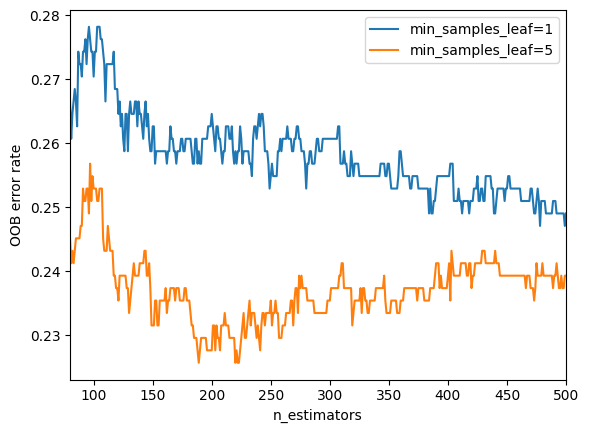

CPU times: user 2min 17s, sys: 1.11 s, total: 2min 18s
Wall time: 2min 22s


In [17]:
%%time
from collections import OrderedDict
ensemble_clfs = [
    (1,
        RandomForestClassifier(warm_start=True,
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth = 10,
                               random_state=seed)),
    (5,
        RandomForestClassifier(warm_start=True,
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth = 10,
                               random_state=seed))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train.values, y_train.values)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show();


In [18]:
err = 100
best_num_estimators = 0
for label, clf_err in error_rate.items():
    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label

print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')


Optimum num of estimators: 223 
min_samples_leaf: 5


Re-train the Random Forest Classifier using the new values for the parameters and calculate the AUC/ROC. Include another parameter, the `max_features`, the number of features to consider when looking for the best split.

In [21]:
### edTest(test_estimators) ###
estimators_rf = RandomForestClassifier(n_estimators= best_num_estimators,
                                    random_state=seed,
                                    oob_score=True,
                                    min_samples_leaf=best_leaf,
                                    max_features='sqrt')

# Fit the model on the entire data
estimators_rf.fit(X_train, y_train);

# Calculate AUC/ROC on the test set
y_proba = estimators_rf.predict_proba(X_test)[:, 1]
estimators_auc = np.round(roc_auc_score(y_test, y_proba),2)
print(f'Educated RF AUC on test set:{estimators_auc}')


Educated RF AUC on test set:0.84


Look at the model's parameters

In [22]:
estimators_rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 223,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

### 3. Performing a cross-validation search

After we have some idea of the range of optimum values for the number of trees and maybe a couple of other parameters, and have enough computing power, you may perform an exhaustive search over other parameter values.

In [23]:
%%time
from sklearn.model_selection import GridSearchCV

do_grid_search = True

if do_grid_search:
    rf = RandomForestClassifier(n_jobs=-1,
                               n_estimators= best_num_estimators,
                               oob_score=True,
                               max_features = 'sqrt',
                               min_samples_leaf=best_leaf,
                               random_state=seed).fit(X_train,y_train)

    param_grid = {
        'min_samples_split': [2,5,None]}

    scoring = {'AUC': 'roc_auc'}

    grid_search = GridSearchCV(rf,
                               param_grid,
                               scoring=scoring,
                               refit='AUC',
                               return_train_score=True,
                               n_jobs=-1)

    results = grid_search.fit(X_train, y_train)
    print(results.best_estimator_.get_params())
    best_rf = results.best_estimator_
    # Calculate AUC/ROC
    y_proba = best_rf.predict_proba(X_test)[:, 1]
    auc = np.round(roc_auc_score(y_test, y_proba),2)
    print(f'GridSearchCV RF AUC on test set:{auc}')


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 223, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}
GridSearchCV RF AUC on test set:0.84
CPU times: user 2.45 s, sys: 191 ms, total: 2.64 s
Wall time: 17.4 s
